Device : cuda:0
(100,) (20, 100, 1)


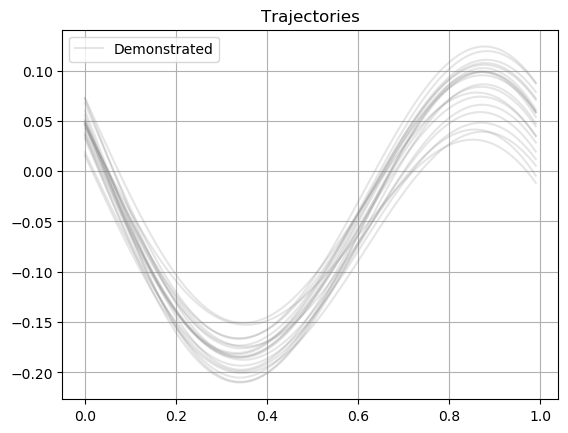

In [1]:
import numpy as np
from movement_primitives.dmp import DMP
from movement_primitives.dmp._dmp import *
import matplotlib.pyplot as plt

import sys
import torch

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)
    

from cnmp import CNMP

from data_generators import *

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

x = np.arange(0,1.00,0.01)
nrTraj=20
sigmaNoise=0.02

A = np.array([.2, .2, .01, -.05])
X = np.vstack((np.sin(5*x), x**2, x, np.ones((1,len(x)))))
Y = np.zeros((nrTraj, len(x)))

for traj in range(nrTraj):
    sample = -np.dot(A + sigmaNoise * np.random.randn(1,4), X)[0]
    Y[traj] = sample
    label = 'Demonstrated' if traj==0 else ''
    plt.plot(x, sample, 'gray', label=label, alpha=0.2)

plt.legend()
plt.grid()
plt.title('Trajectories')

Y = np.expand_dims(Y, -1)
print(x.shape, Y.shape)

In [2]:
dx, dy = 1, 1
num_trajs, num_steps, num_dims = Y.shape
num_demos = int(num_trajs*.8)  # 80% of the data is used for training
num_test = num_trajs - num_demos
t_steps = num_steps

n_max, m_max = 10, 10

In [3]:
from copy import deepcopy


dt = 1/num_steps
dz = dx

d_ = DMP(n_dims=num_dims, n_weights_per_dim=6, dt=dt)

forcing_terms = np.zeros_like(Y)
phases = np.zeros_like(Y)

for i in range(num_trajs):
    d = deepcopy(d_)
    d.imitate(x, Y[i])
    
    for j, t in enumerate(np.arange(0, 1, dt)):
        z = d.forcing_term.phase(t)  # Calculate the phase
        phases[i, j] = z
        forcing_terms[i, j] = d.forcing_term.forcing_term(z).squeeze()

y_train, y_test = torch.from_numpy(forcing_terms[:num_demos]), torch.from_numpy(forcing_terms[num_demos:])
x_train, x_test = torch.from_numpy(phases[:num_demos]), torch.from_numpy(phases[num_demos:])

y_train, y_test = (y_train/1000).to(device), (y_test/1000).to(device)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([16, 100, 1]) torch.Size([16, 100, 1])
torch.Size([4, 100, 1]) torch.Size([4, 100, 1])


In [4]:
batch_size = 1

model_ = CNMP(input_dim=dx, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=[64, 64], decoder_hidden_dims=[64, 64], batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=3e-4, params=model_.parameters())

pytorch_total_params = sum(p.numel() for p in model_.parameters())
print(pytorch_total_params)


if torch.__version__ >= "2.0":
    model = torch.compile(model_)
else:
    model = model_

8706


In [5]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(5, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = x_train[traj_id, n_ids]
        obs[i, :n, dx:] = traj[n_ids]  # SM(t)
        obs_mask[i, :n] = True
        
        tar_x[i, :m, :dx] = x_train[traj_id, m_ids]
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list, fixed_ind=None):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        if fixed_ind != None:
            n_ids[-1] = fixed_ind
        
        val_obs[i, :n, :dx] = x_test[traj_id, n_ids]
        val_obs[i, :n, dx:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i, :, :dx] = x_test[traj_id]
        val_tar_y[i] = traj[m_ids]

In [6]:
import time
import os

timestamp = int(time.time())
root_folder = f'../outputs/force/cnmp/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(y_train, f'{root_folder}y.pt')

epochs = 100_000
epoch_iter = num_demos // batch_size
v_epoch_iter = num_test//batch_size
avg_loss, avg_loss1, avg_loss_cnmp = 0, 0, 0
loss_report_interval = 500
val_per_epoch = 1000
min_val_loss, min_val_loss1, min_val_loss_cnmp = 1000000, 1000000, 1000000
mse_loss = torch.nn.MSELoss()

plot_test = True

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        optimizer.zero_grad()
        
        pred = model(obs, tar_x, obs_mask)

        loss = model.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % val_per_epoch == 0 and epoch > 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(num_test)[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss = 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(y_test, v_traj_ids[j])
                pred = model.val(val_obs, val_tar_x, val_obs_mask)
                if plot_test:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}test_{epoch}_{j}_{k}.png')
                        plt.clf()
                val_loss += mse_loss(pred[:, :, :model.output_dim], val_tar_y).item()

            val_loss /= v_epoch_iter
                
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'New best: {min_val_loss}')
                torch.save(model_.state_dict(), f'{root_folder}saved_models/best_cnmp.pt')

    epoch_loss /= epoch_iter
    avg_loss += epoch_loss

    if epoch % loss_report_interval == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss / loss_report_interval))
        avg_loss = 0

Epoch: 0, Loss: 0.0008497238494455814
Epoch: 500, Loss: -2.8695225387983956
New best: 3.1208265227178345e-05
Epoch: 1000, Loss: -3.4023098472617566
Epoch: 1500, Loss: -3.5194824931025503
Epoch: 2000, Loss: -3.5933152186870574
Epoch: 2500, Loss: -3.667379205405712
New best: 6.152405262582761e-06
Epoch: 3000, Loss: -3.9043574317824095
Epoch: 3500, Loss: -4.211105825006147
Epoch: 4000, Loss: -4.365049584688618
Epoch: 4500, Loss: -4.542303566507995
Epoch: 5000, Loss: -4.621912616604008
Epoch: 5500, Loss: -4.652966609643772
New best: 2.154861306280509e-06
Epoch: 6000, Loss: -4.726219326427439
Epoch: 6500, Loss: -4.795371900117025
Epoch: 7000, Loss: -4.841046227071434
Epoch: 7500, Loss: -4.860887037275359
New best: 1.6070899562237173e-06
Epoch: 8000, Loss: -4.930226101197302
Epoch: 8500, Loss: -4.937748738259077
New best: 1.3066309634268691e-06
Epoch: 9000, Loss: -4.962132043365389
Epoch: 9500, Loss: -4.982743979662657
New best: 9.93755094214066e-07
Epoch: 10000, Loss: -5.014840312469751
Epo

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Trajectories')

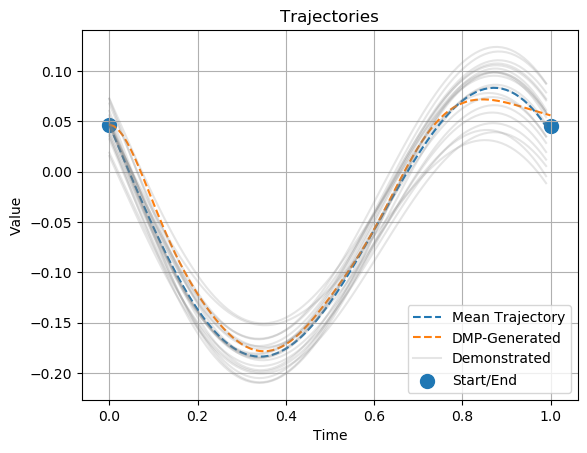

In [7]:
d = deepcopy(d_)
mean_Y = np.mean(Y, axis=0)
d.imitate(x, mean_Y)
sy, ey = mean_Y[0], mean_Y[-1]
d.configure(start_y=sy, goal_y=ey)

p = plt.plot(x, mean_Y, label='Mean Trajectory', linestyle='--')
plt.scatter([0, 1], [sy, ey], color=p[0].get_color(), s=100, label='Start/End')

t, traj1 = d.open_loop()
p = plt.plot(t, traj1.squeeze(), label='DMP-Generated', linestyle='--')

for traj in range(nrTraj):
    label = 'Demonstrated' if traj==0 else ''
    plt.plot(x, Y[traj], 'gray', label=label, alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.title('Trajectories')

Text(0.5, 1.0, 'Trajectories')

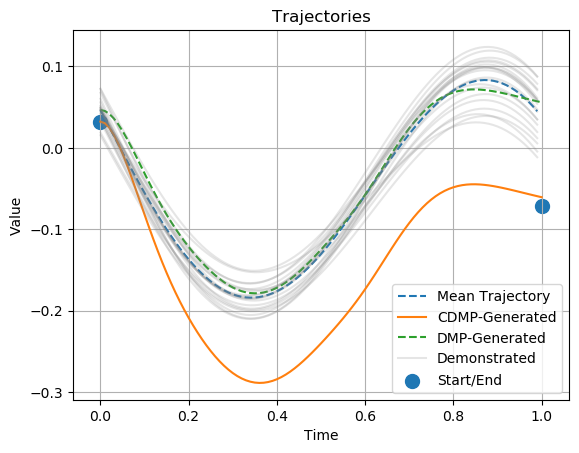

In [16]:
ind = 4

d = deepcopy(d_)
mean_Y = np.mean(Y, axis=0)
d.imitate(x, mean_Y)
sy, ey = mean_Y[0], mean_Y[-1]
sy = Y[ind][0]
ey = Y[ind][-1]-0.1
d.configure(start_y=sy, goal_y=ey)

set_model(model)

p = plt.plot(x, mean_Y, label='Mean Trajectory', linestyle='--')
plt.scatter([0, 1], [sy, ey], color=p[0].get_color(), s=100, label='Start/End')

t, traj2 = d.open_loop()
plt.plot(t, traj2.squeeze(), label='CDMP-Generated', linestyle='-')
p = plt.plot(t, traj1.squeeze(), label='DMP-Generated', linestyle='--')

for traj in range(nrTraj):
    label = 'Demonstrated' if traj==0 else ''
    plt.plot(x, Y[traj], 'gray', label=label, alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.title('Trajectories')